In [229]:
import matplotlib.pyplot as plt
import numpy as np

class Radionuclide_lara:
    def __init__(self, name):
        self.name = name

    @property
    def radionuclide_data(self):
        file_path = f"{self.name}.lara.txt"
        rn_data = {}
        emissions = []
        with open(file_path, encoding='utf-8') as f:
            lines = [line.strip() for line in f if line.strip()]
            section = None
            for line in lines:
                if line.startswith('Emissions') or line.startswith('Energy (keV)'):
                    section = 'emissions'
                    continue
                if section == 'emissions':
                    if line.startswith('=') or line.startswith('-'):
                        continue
                    # Parse emission lines
                    parts = [p.strip() for p in line.split(';')]
                    if len(parts) >= 8:
                        emissions.append({
                            'Energy (keV)': parts[0],
                            'Ener. unc. (keV)': parts[1],
                            'Intensity (%)': parts[2],
                            'Int. unc. (%)': parts[3],
                            'Type': parts[4],
                            'Origin': parts[5],
                            'Lvl. start': parts[6],
                            'Lvl. end': parts[7],
                        })
                else:
                    if ';' in line:
                        key, *values = [p.strip() for p in line.split(';')]
                        if len(values) == 1:
                            rn_data[key] = values[0]
                        else:
                            rn_data[key] = values
        rn_data['Emissions'] = emissions
        return rn_data
    
    def get_rays_emission_data(self, energy_filter=None, intensity_filter=None, photon_only=False):
        rays_energies =  np.array([float(em['Energy (keV)']) for em in self.radionuclide_data["Emissions"]])
        rays_intensities = np.array([float(em['Intensity (%)']) for em in self.radionuclide_data["Emissions"]])
        rays_types = np.array([em['Type'] for em in self.radionuclide_data["Emissions"]])

        # Apply energy filter if specified
        if energy_filter is not None:
            mask = rays_energies >= energy_filter
            rays_energies = rays_energies[mask]
            rays_intensities = rays_intensities[mask]
            rays_types = rays_types[mask]

        # Apply intensity filter if specified
        if intensity_filter is not None:
            mask = rays_intensities >= intensity_filter
            rays_energies = rays_energies[mask]
            rays_intensities = rays_intensities[mask]
            rays_types = rays_types[mask]

        # Filter for photon emissions only if requested
        if photon_only:
            mask = np.isin(rays_types, ['g']) | np.char.startswith(rays_types, 'X')
            rays_energies = rays_energies[mask]
            rays_intensities = rays_intensities[mask]
            rays_types = rays_types[mask]
        return rays_energies, rays_intensities, rays_types

    def plot_emissions(self, saving_figure:bool=False, photon_only:bool=False):
        rays_energies, rays_intensities, rays_types = self.get_rays_emission_data(photon_only=photon_only)

        gamma_rays_energies = rays_energies[rays_types == 'g']
        gamma_rays_intensities = rays_intensities[rays_types == 'g']
        x_rays_energies = rays_energies[np.char.startswith(rays_types, 'X')]
        x_rays_intensities = rays_intensities[np.char.startswith(rays_types, 'X')]

        alpha_rays_energies = rays_energies[rays_types == 'a']
        alpha_rays_intensities = rays_intensities[rays_types == 'a']

        if photon_only:
            max_energy = max(
            max(gamma_rays_energies) if len(gamma_rays_energies) > 0 else 0,
            max(x_rays_energies) if len(x_rays_energies) > 0 else 0)
            min_energy = min(
            min(gamma_rays_energies) if len(gamma_rays_energies) > 0 else 0,
            min(x_rays_energies) if len(x_rays_energies) > 0 else 0)
        else:
            max_energy = max(
                max(gamma_rays_energies) if len(gamma_rays_energies) > 0 else 0,
                max(x_rays_energies) if len(x_rays_energies) > 0 else 0,
                max(alpha_rays_energies) if len(alpha_rays_energies) > 0 else 0)
            min_energy = min(
                min(gamma_rays_energies) if len(gamma_rays_energies) > 0 else 0,
                min(x_rays_energies) if len(x_rays_energies) > 0 else 0,
                min(alpha_rays_energies) if len(alpha_rays_energies) > 0 else 0)

        delta_energy = max_energy - min_energy
        width = delta_energy // 110 if delta_energy > 0 else 1
        if len(gamma_rays_energies) != 0:
            plt.bar(gamma_rays_energies, gamma_rays_intensities, width=width, label ='Gamma Emissions', color='blue', alpha=1)
        if len(x_rays_energies) != 0:
            plt.bar(x_rays_energies, x_rays_intensities, width=width, label ='X Emissions', color='orange', alpha=1)
        if len(alpha_rays_energies) != 0:
            plt.bar(alpha_rays_energies, alpha_rays_intensities, width=width, label ='Alpha Emissions', color='green', alpha=1)
        plt.xlabel('Energy [keV]')
        plt.ylabel('Intensity [%]')
        plt.title(f'Emissions of {self.name}')
        plt.yscale('log')
        plt.grid()
        plt.legend()
        plt.savefig(f"{self.name}_emissions.png") if saving_figure else None
        plt.show()

In [233]:
cobalt = Radionuclide_lara("Co-60")
print(cobalt.name)
print(cobalt.radionuclide_data)


Co-60
{'Nuclide': 'Co-60', 'Element': 'Cobalt', 'Z': '27', 'Daughter(s)': ['(B-)', 'Ni-60', '100'], 'Q-': '2823.07', 'Possible parent(s)': ['(I.T.)', 'Co-60m', '99.75'], 'Half-life (a)': ['5.2711', '0.0008'], 'Half-life (s)': ['166.340E6', '0.025E6'], 'Decay constant (1/s)': ['4.1671E-9', '0.0006E-9'], 'Specific activity (Bq/g)': ['41.824E12', '0.006E12'], 'Reference': 'INEEL - 2006', 'Emissions': [{'Energy (keV)': '0.84', 'Ener. unc. (keV)': '', 'Intensity (%)': '0.0002', 'Int. unc. (%)': '', 'Type': 'XL', 'Origin': 'Ni-60', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '7.46097', 'Ener. unc. (keV)': '', 'Intensity (%)': '0.00334', 'Int. unc. (%)': '0.00012', 'Type': 'XKa2', 'Origin': 'Ni-60', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '7.47824', 'Ener. unc. (keV)': '', 'Intensity (%)': '0.0065', 'Int. unc. (%)': '0.0003', 'Type': 'XKa1', 'Origin': 'Ni-60', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '8.2967', 'Ener. unc. (keV)': '', 'Intensity (%)': '0.00136', 

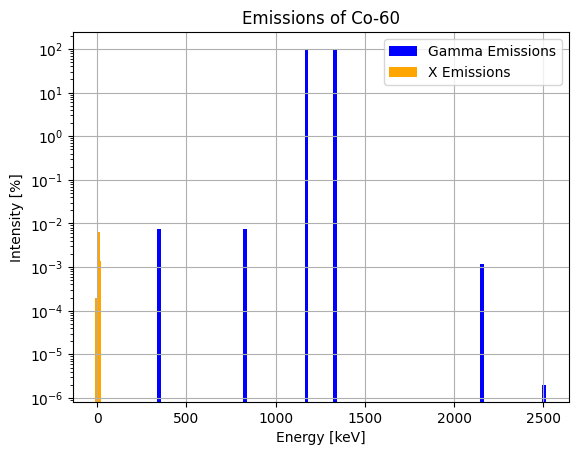

In [235]:
cobalt.plot_emissions(saving_figure=True, photon_only=False)